In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.linear_model import ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, KFold, ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from aging.plotting import figure, legend, format_plots, PlotConfig, save_factory
import joblib

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "methylation_model", tight_layout=False)

In [100]:
beh_df = pd.read_parquet(
    # "/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v2.parquet"
    # '/n/scratch/users/w/wg41/bio-age-model/ontogeny-predictions.parquet'
    '/n/scratch/users/w/wg41/bio-age-model/combined-results-ontogeny-predictions.parquet'
)

In [ ]:
meth_df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/epigenetics/analysis/epi_df.parquet"
)

meth_df = meth_df.astype(float).sort_index(level='age')

In [101]:
beh_reindexed = beh_df.loc[pd.IndexSlice[:, :, :, :, meth_df.index.get_level_values('uuid')], :].copy()
beh_reindexed = pd.DataFrame(beh_reindexed.mean(1).rename('bio_age'))
age = beh_reindexed.index.get_level_values('age')

In [102]:
beh_reindexed

bio_age
age mouse     subject_name session_name uuid                                 date                          
4   4M_01_01  4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30   6.629041
    4M_02_03  4M_02_03     otgy_4M_02   32221902-9ee7-4d36-a7f4-e76375e3084e 2023-12-01 12:54:38   4.731108
    4M_03_01  4M_03_01     otgy_4M_03   d217e548-3541-4f7a-8b3a-448f4544d543 2023-12-01 14:43:51   3.804557
    4M_04_03  4M_04_03     otgy_4M_04   74731140-1b31-4027-9ebb-c1f21bb1cffa 2023-12-01 16:08:40   1.368627
8   8M_01_01  8M_01_01     otgy_8M_01   f6753e99-2eb6-47d7-85d6-962aa1b9f945 2023-12-02 10:57:04  12.412506
    8M_02_04  8M_02_04     otgy_8M_02   763376b8-9f53-454c-8012-fca55ae57519 2023-12-02 10:10:14  11.187072
    8M_03_01  8M_03_01     otgy_8M_03   18b6bc57-b133-4366-bda2-9385a5c6927b 2023-12-02 15:11:12   9.458505
    8M_04_04  8M_04_04     otgy_8M_04   f1fd0bed-40f3-4c03-93a5-67054db2d402 2023-12-02 14:16:17  12.387595
12  12M_01_02 12M_01_02    otgy_12M_01  eb4a613e-5aae-47e2-877d-30fe03cdb34b 2023-12-02 09:28:18  46.849289
    12M_02_01 12M_02_01    otgy_12M_02  3dfccca3-d4a6-45cf-8b10-b1ccab35a562 2023-12-02 14:30:46  12.776152
    12M_03_01 12M_03_01    otgy_12M_03  83166f68-4012-4bc2-834c-bba962bea93b 2023-12-02 16:33:34   8.646530
    12M_04_01 12M_04_01    otgy_12M_04  50d29f68-865e-4abd-a289-9bd962c746b1 2023-12-02 18:34:44  15.441233
52  52M_01_01 52M_01_01    otgy_52M_01  3b42a150-a006-4da1-9f8a-225b4fe6b475 2023-12-02 11:48:03  54.271656
    52M_02_01 52M_02_01    otgy_52M_02  572431a4-031d-4dec-86bb-e3f54a6bcd69 2023-12-02 13:50:56  71.776474
    52M_03_01 52M_03_01    otgy_52M_03  858ec3dc-8833-4a73-85d0-5261faea88df 2023-12-02 15:52:44  53.848225
    52M_04_01 52M_04_01    otgy_52M_04  f737fe26-d341-42d4-802a-598b171ebf79 2023-12-02 17:55:33  56.473450
78  78M_01_01 78M_01_01    otgy_78M_01  b66dec5c-2791-46df-a8e5-8fe3c0f523ce 2023-12-04 10:30:45  77.136505
    78M_02_01 78M_02_01    otgy_78M_02  e5df3882-e8e7-4a06-9a70-a0af576c1507 2023-12-04 11:17:50  88.862846
    78M_03_01 78M_03_01    otgy_78M_03  042e0073-6534-4d5e-8a15-5c28b7b7df25 2023-12-04 11:56:47  71.153793
    78M_04_03 78M_04_03    otgy_78M_04  6dd5fa9f-da17-4bd0-a53e-5be82f8c6a83 2023-12-04 12:37:19  80.877586
90  90M_01_01 90M_01_01    otgy_90M_01  f16e4f35-68c7-45cc-b82d-d0abb848c243 2023-12-01 12:05:47  80.772972
    90M_02_01 90M_02_01    otgy_90M_02  6b576754-f68d-435b-a0cd-a79ace0ae05a 2023-12-01 13:47:18  73.664436
    90M_03_01 90M_03_01    otgy_90M_03  7fb6dba6-ea7f-4043-9b5d-c532e312de1a 2023-12-01 15:26:36  77.928566
    90M_04_01 90M_04_01    otgy_90M_04  3b97044c-14c6-416f-be9e-6d3899d2b04e 2023-12-01 16:55:39  84.972343

In [52]:
def zscore(arr):
    return (arr - arr.mean()) / arr.std()

### Methylation data feature selection

Choose the features with the highest variance

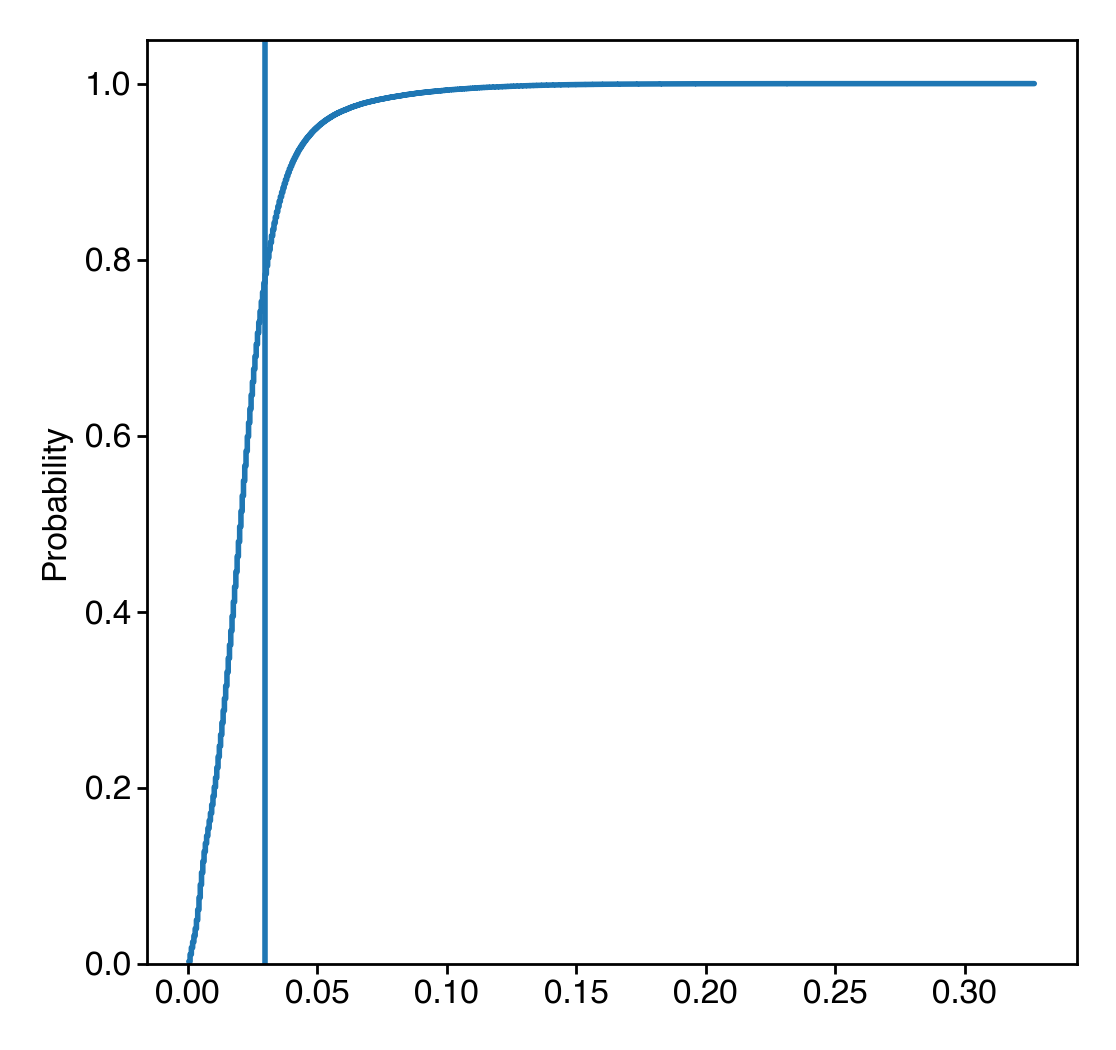

In [53]:
ax = sns.histplot(meth_df.std(), cumulative=True, stat='probability', element='step', fill=False)
ax.axvline(0.03)

In [54]:
keep_genes = meth_df.std() > 0.05
keep_genes = keep_genes.index[keep_genes]

In [55]:
filt_meth_df = meth_df[keep_genes]

In [56]:
resid = zscore(beh_reindexed['bio_age'].to_numpy() - age.to_numpy())

In [65]:
pipeline = make_pipeline(
    StandardScaler(),
    ElasticNet(max_iter=10_000),
)

In [62]:
params = {
    'elasticnet__l1_ratio': np.linspace(0.05, 0.3, 4),
    'elasticnet__alpha': np.logspace(-1, 1, 4),
}

grid = ParameterGrid(params)

In [63]:
out = []
for param_set in tqdm(list(grid)):
    pipeline.set_params(**param_set)
    _score = r2_score(
        resid,
        cross_val_predict(
            pipeline.set_params(**param_set),
            filt_meth_df,
            resid[:, None],
            cv=KFold(n_splits=7, shuffle=True, random_state=0),
            n_jobs=-1,
        ).squeeze(),
    )
    param_set['score'] = _score
    out.append(param_set)
out = pd.DataFrame(out)

  0%|          | 0/16 [00:00<?, ?it/s]

<Axes: xlabel='elasticnet__alpha', ylabel='elasticnet__l1_ratio'>

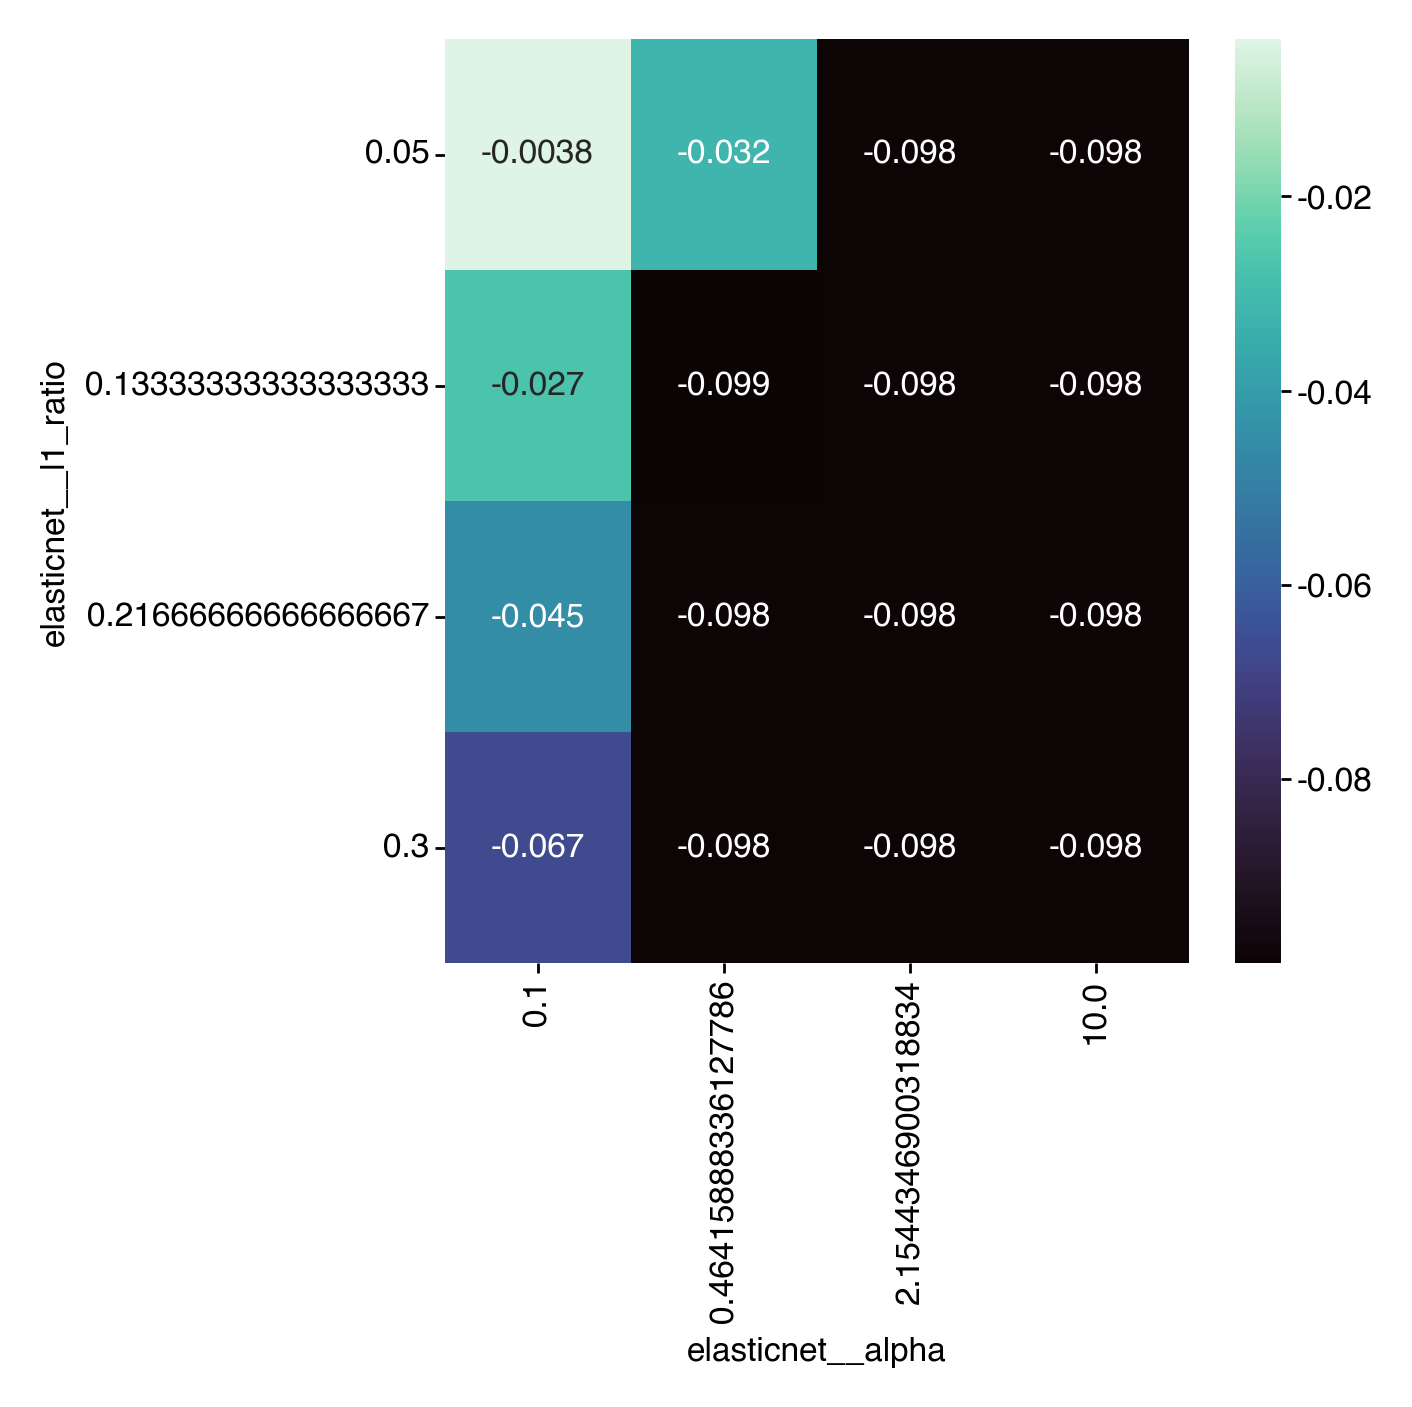

In [64]:
sns.heatmap(
    pd.pivot_table(
        out,
        index="elasticnet__l1_ratio",
        columns="elasticnet__alpha",
        values="score",
    ),
    cmap="mako",
    # vmin=0,
    annot=True
)

[None]

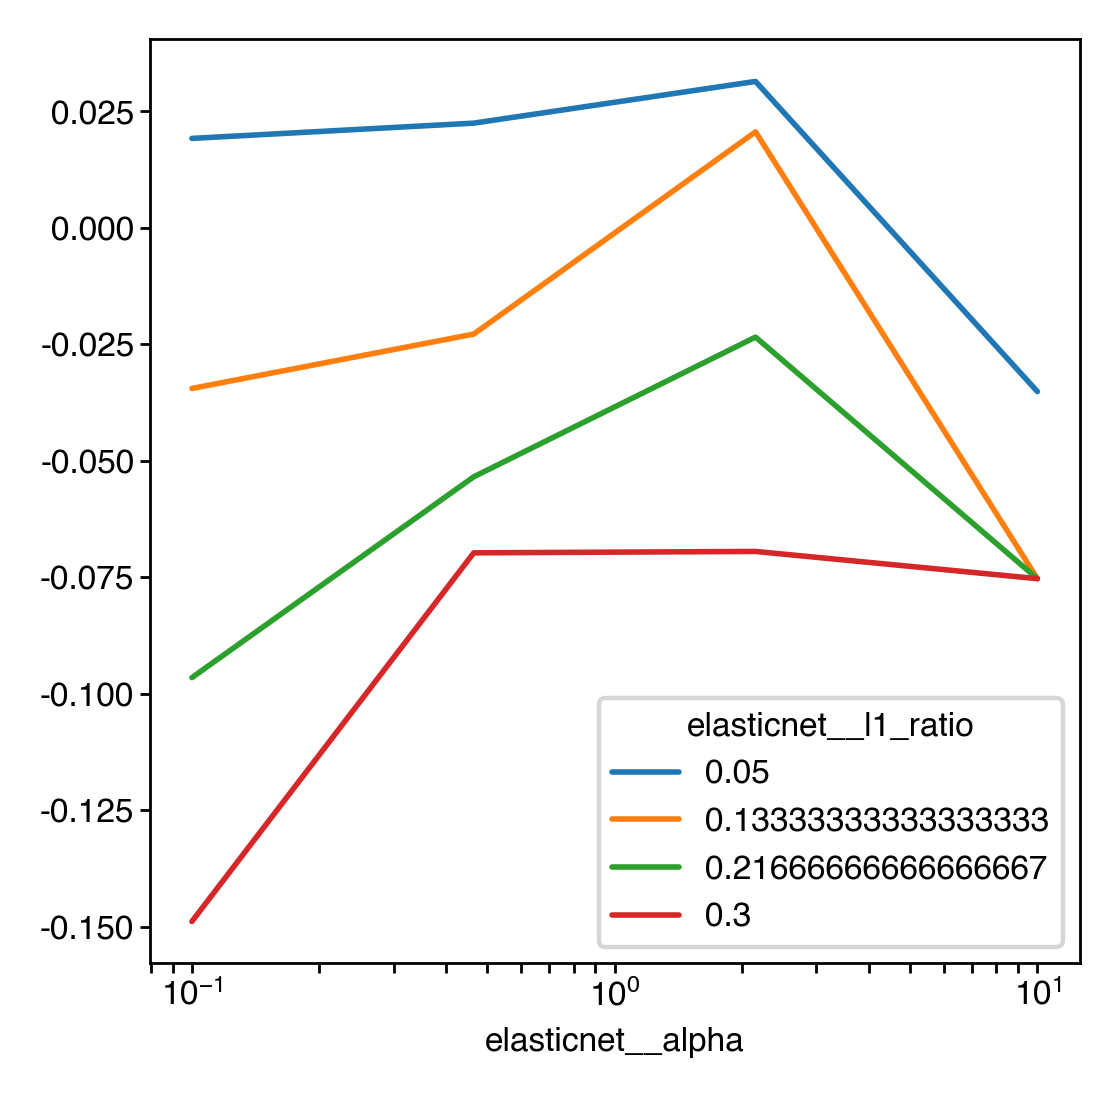

In [47]:
ax = pd.pivot_table(out, index='elasticnet__l1_ratio', columns='elasticnet__alpha', values='score').T.plot()
ax.set(xscale='log')

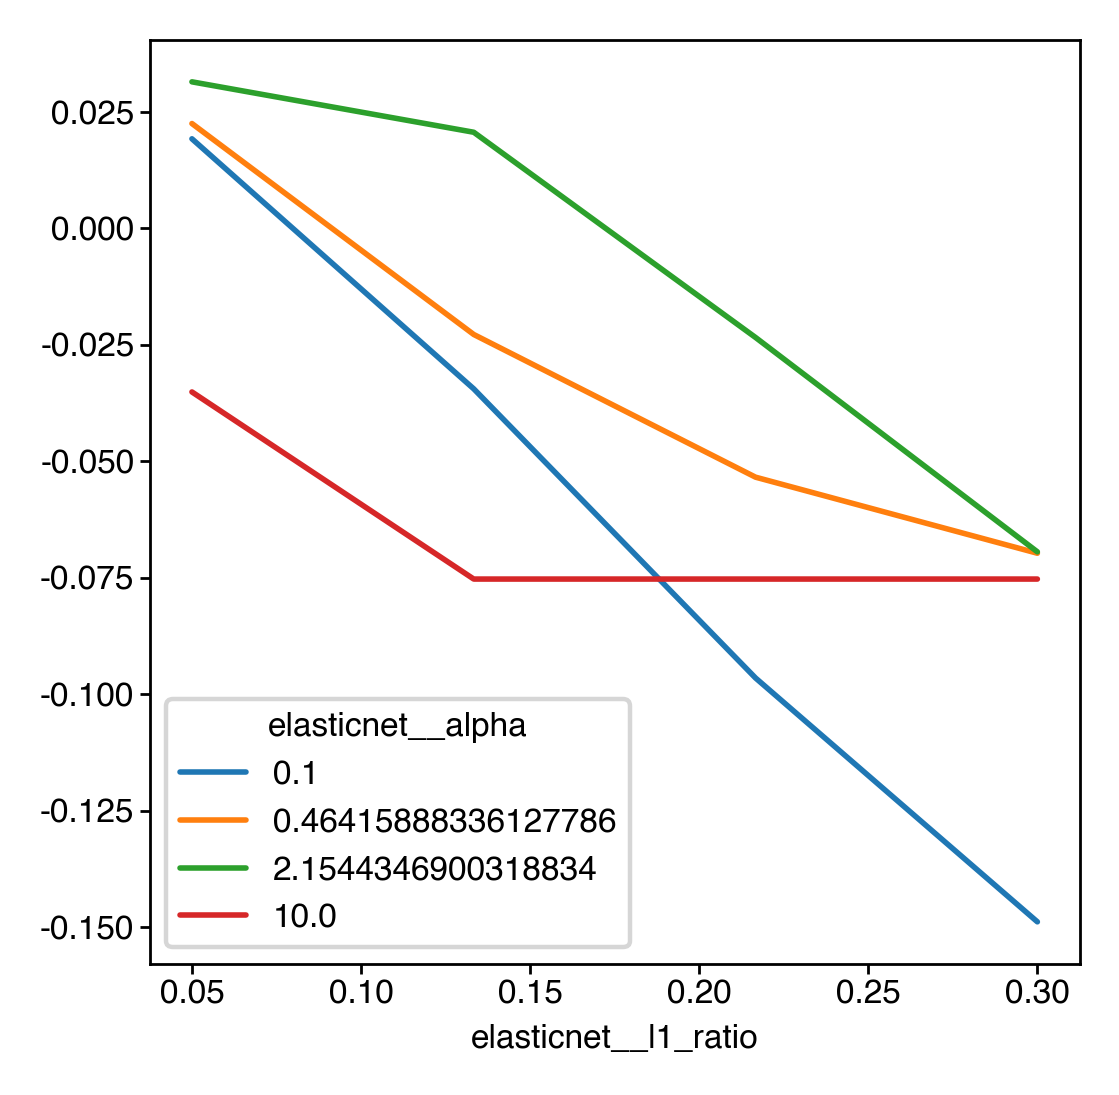

In [48]:
ax = pd.pivot_table(out, index='elasticnet__l1_ratio', columns='elasticnet__alpha', values='score').plot()

In [22]:
param_set

{'elasticnet__alpha': 1.0,
 'elasticnet__l1_ratio': 1.0,
 'score': -0.07529071164514711}

In [94]:
y = zscore(beh_reindexed['bio_age'].to_numpy())

In [95]:
pipeline = make_pipeline(
    StandardScaler(),
    PLSRegression(n_components=2),
)

In [96]:
_score = r2_score(
    y,
    cross_val_predict(
        pipeline,
        filt_meth_df,
        y[:, None],
        cv=KFold(n_splits=7, shuffle=True, random_state=0),
        n_jobs=-1,
    ).squeeze(),
)
_score

0.8727408471833485

In [97]:
y = zscore(age.to_numpy())

In [98]:
_score = r2_score(
    y,
    cross_val_predict(
        pipeline,
        filt_meth_df,
        y[:, None],
        cv=KFold(n_splits=7, shuffle=True, random_state=0),
        n_jobs=-1,
    ).squeeze(),
)
_score

0.9468024508549012

In [74]:
param_set = {
    'elasticnet__alpha': 0.1,
    'elasticnet__l1_ratio': 0.5,
}
_score = r2_score(
    resid,
    cross_val_predict(
        pipeline.set_params(**param_set),
        filt_meth_df,
        resid[:, None],
        cv=KFold(n_splits=7, shuffle=True, random_state=0),
        n_jobs=-1,
    ).squeeze(),
)
_score

0.22073023564611804

In [ ]:
p = pipeline.set_params(**param_set)
p.fit(filt_meth_df, resid[:, None])

In [90]:
coefs = p.named_steps['elasticnet'].coef_

In [91]:
coefs.shape

(13864,)

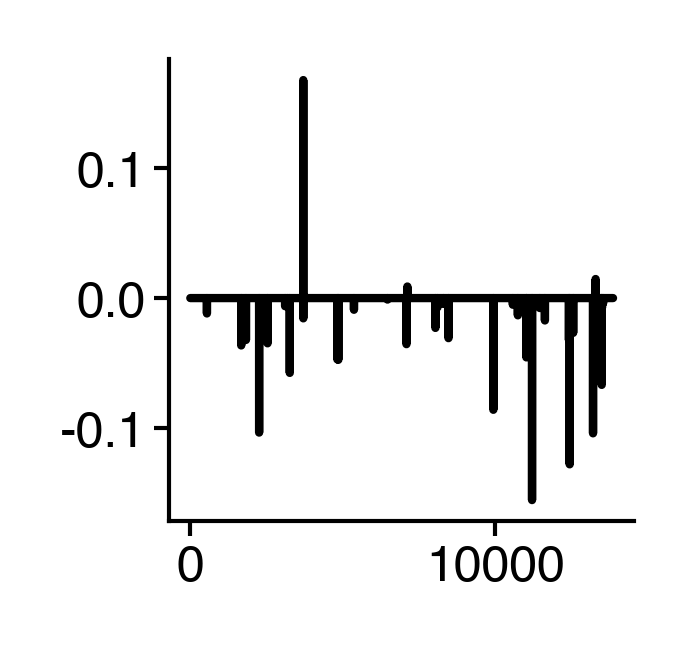

In [87]:
fig = figure(1, 1)
plt.plot(coefs, color='k')
sns.despine()

In [88]:
np.sum(coefs != 0)

38

### Run bootstrap for r2

In [127]:
n_boot = 100
param_set = {
    "elasticnet__alpha": 0.1,
    "elasticnet__l1_ratio": 0.5,
}
p = pipeline.set_params(**param_set)
np.random.seed(0)

scores = {
    "mae": [],
    "r2": [],
}
for i in tqdm(range(n_boot)):
    # idx = np.random.choice(np.arange(len(resid)), len(resid))
    # x = filt_meth_df.iloc[idx]
    # y = resid[idx][:, None]
    x = filt_meth_df
    y = resid[:, None]
    preds = cross_val_predict(
        p,
        x,
        y,
        # cv=KFold(n_splits=7, shuffle=True, random_state=0),
        cv=KFold(n_splits=7, shuffle=True, random_state=i),
        n_jobs=-1,
    ).squeeze()
    scores["r2"].append(r2_score(y, preds))
    scores["mae"].append(mean_absolute_error(y, preds))

  0%|          | 0/100 [00:00<?, ?it/s]

In [128]:
param_set = {
    "elasticnet__alpha": 0.1,
    "elasticnet__l1_ratio": 0.5,
}
p = pipeline.set_params(**param_set)
np.random.seed(0)

shuff_scores = {
    "mae": [],
    "r2": [],
}
for i in tqdm(range(n_boot)):
    # idx = np.random.choice(np.arange(len(resid)), len(resid))
    # x = filt_meth_df.iloc[idx]
    # y = resid[idx][:, None]
    x = filt_meth_df
    y = resid[:, None]
    np.random.shuffle(y)
    preds = cross_val_predict(
        p,
        x,
        y,
        # cv=KFold(n_splits=7, shuffle=True, random_state=0),
        cv=KFold(n_splits=7, shuffle=True, random_state=i),
        n_jobs=-1,
    ).squeeze()
    shuff_scores["r2"].append(r2_score(y, preds))
    shuff_scores["mae"].append(mean_absolute_error(y, preds))

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_16615/2880265538.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel='Heldout R2', xticklabels=['Observed', 'Shuffle'], ylim=(None, 0.5))


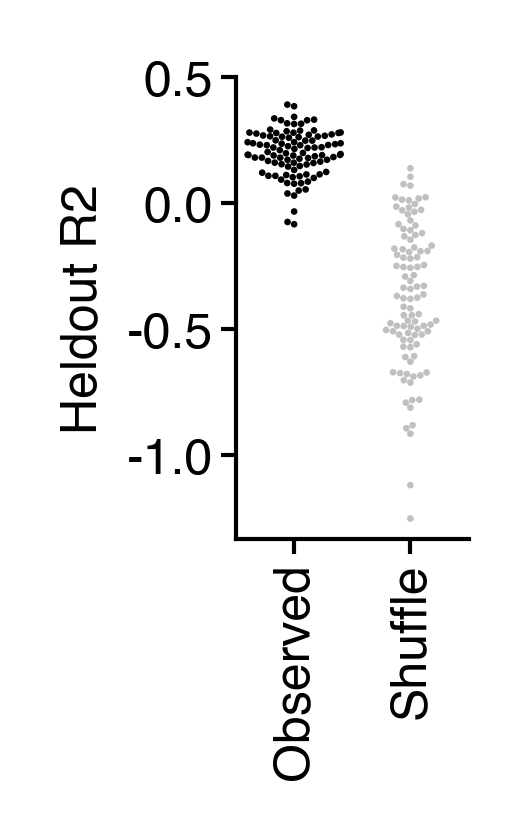

In [133]:
fig = figure(0.5, 1)
ax = sns.swarmplot(data=[scores['r2'], shuff_scores['r2']], size=0.8, palette=['k', 'silver'])
ax.set(ylabel='Heldout R2', xticklabels=['Observed', 'Shuffle'], ylim=(None, 0.5))
plt.xticks(rotation=90)
sns.despine()
saver(fig, "heldout-r2");

/tmp/ipykernel_16615/3656409749.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(ylabel='Heldout MAE', xticklabels=['Observed', 'Shuffle'], ylim=(0, None))
/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


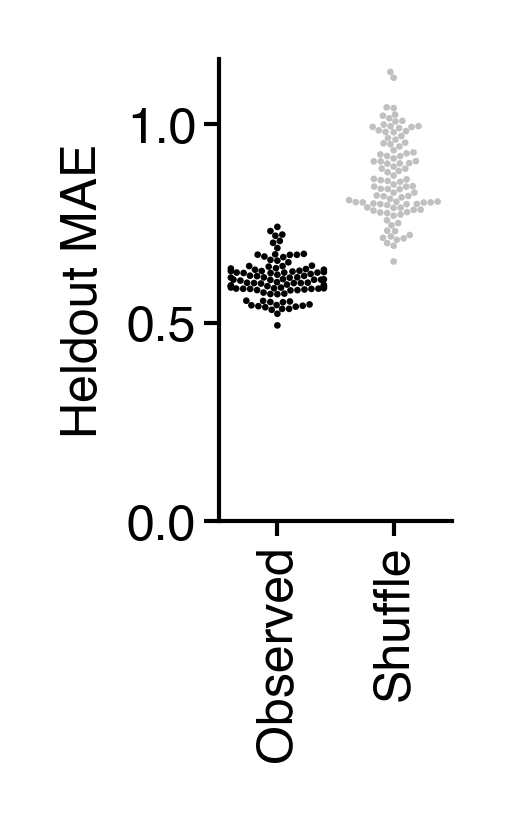

In [134]:
fig = figure(0.5, 1)
ax = sns.swarmplot(data=[scores['mae'], shuff_scores['mae']], size=0.8, palette=['k', 'silver'])
ax.set(ylabel='Heldout MAE', xticklabels=['Observed', 'Shuffle'], ylim=(0, None))
plt.xticks(rotation=90)
sns.despine()
saver(fig, "heldout-mae");

In [151]:
x = filt_meth_df
y = resid[:, None]
preds = cross_val_predict(
    p,
    x,
    y,
    cv=KFold(n_splits=7, shuffle=True, random_state=3),
    n_jobs=-1,
).squeeze()


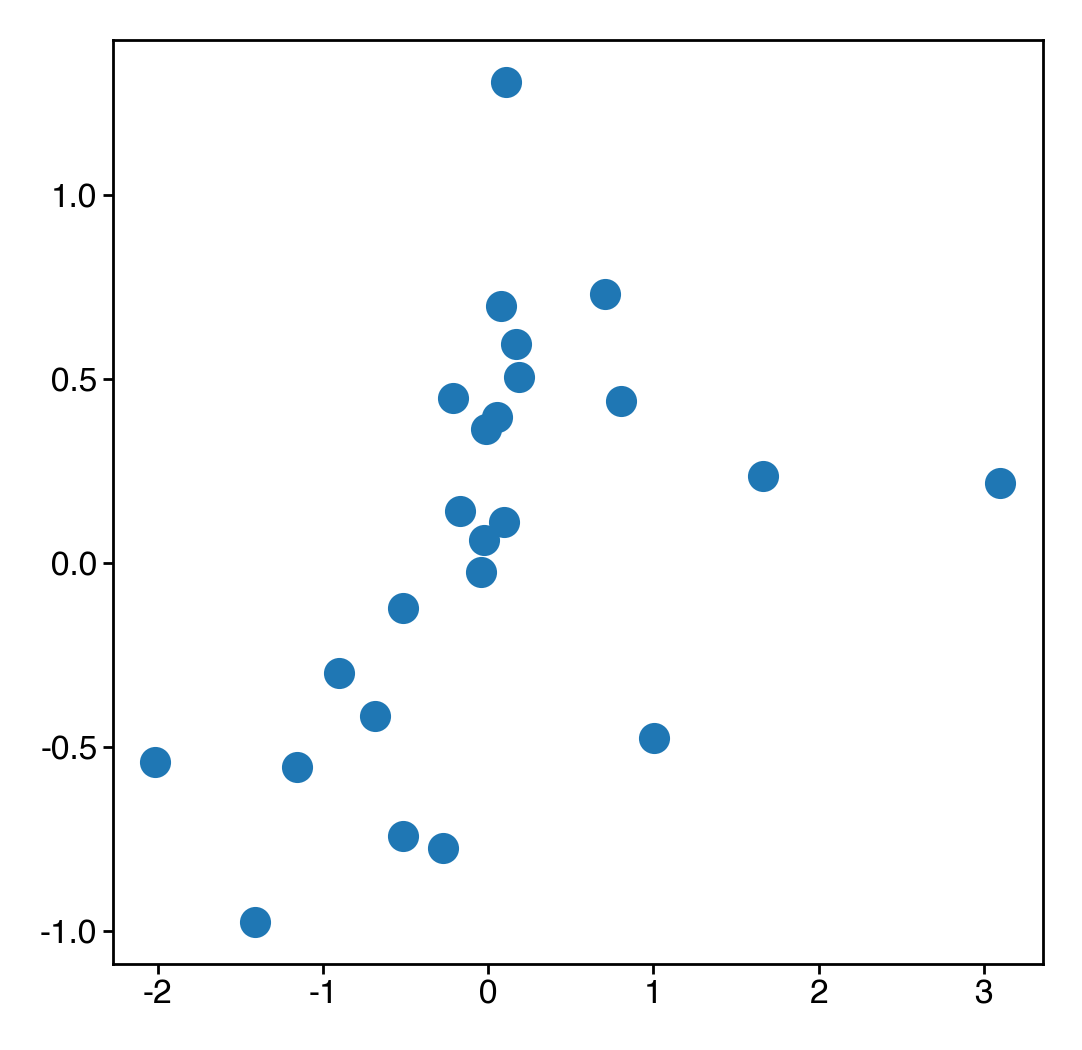

In [152]:
plt.scatter(y, preds)

## Do same thing, but using just the few features that come from the lasso regression